In [2]:
from IPython.display import Markdown, display
bash = lambda commands: display(Markdown("```bash\n" + ' && \n'.join(commands) + "\n```"))
fasta = "/vol/bitbucket/bl1821/frankenstein/data/atotc.fasta"
pod5 = "/vol/bitbucket/bl1821/frankenstein/data/atotc.pod5"
pod5_short = "/vol/bitbucket/bl1821/frankenstein/data/atotc_short.pod5"

bonito_env = "source /vol/bitbucket/bl1821/bonito_env/bin/activate"
dorado_env = "source /vol/bitbucket/bl1821/pyenv/bin/activate"

A complete single one-shot pruning workflow is like follows:

In [85]:
# sparsities = sorted(set([a/10 for a in range(10)] + [1-0.5**a for a in range(1,5)] + [1-0.75**a for a in range(1,9)]))
sparsities = [1-0.75**a for a in range(1,9)]
bash([
f"""for i in {' '.join([str(s) for s in sparsities])}; do
  {bonito_env} &&
  python3 one_shot_masked.py ../models/bje ${{i}} sparse_${{i}} &&
  bonito export sparse_${{i}} --output sparse_${{i}}/export &&
  bonito train sparse_${{i}}_retrained --directory ../models/train_data/je --epochs 5 --chunks 200 --valid-chunks 50 --pretrained sparse_${{i}} --batch 32 &&
  bonito export sparse_${{i}}_retrained --output sparse_${{i}}_retrained/export &&
  {dorado_env} &&
  dorado basecaller sparse_${{i}}/export {pod5} --reference {fasta} > sparse_${{i}}/run.bam 2> >(tee sparse_${{i}}/run.log >&2) &&
  dorado summary sparse_${{i}}/run.bam > sparse_${{i}}/run.tsv &&
  dorado basecaller sparse_${{i}}/export {pod5_short} --reference {fasta} > sparse_${{i}}/short.bam 2> >(tee sparse_${{i}}/short.log >&2) &&
  dorado summary sparse_${{i}}/short.bam > sparse_${{i}}/short.tsv &&
  dorado basecaller sparse_${{i}}_retrained/export {pod5} --reference {fasta} > sparse_${{i}}_retrained/run.bam 2> >(tee sparse_${{i}}_retrained/run.log >&2) &&
  dorado summary sparse_${{i}}_retrained/run.bam > sparse_${{i}}_retrained/run.tsv
  dorado basecaller sparse_${{i}}_retrained/export {pod5_short} --reference {fasta} > sparse_${{i}}_retrained/short.bam 2> >(tee sparse_${{i}}_retrained/short.log >&2) &&
  dorado summary sparse_${{i}}_retrained/short.bam > sparse_${{i}}_retrained/short.tsv
done""",
  "mkdir -p one_shot",
  "mv sparse* one_shot"
])

```bash
for i in 0.25 0.4375 0.578125 0.68359375 0.7626953125 0.822021484375 0.86651611328125 0.8998870849609375; do
  source /vol/bitbucket/bl1821/bonito_env/bin/activate &&
  python3 one_shot_masked.py ../models/bje ${i} sparse_${i} &&
  bonito export sparse_${i} --output sparse_${i}/export &&
  bonito train sparse_${i}_retrained --directory ../models/train_data/je --epochs 5 --chunks 200 --valid-chunks 50 --pretrained sparse_${i} --batch 32 &&
  bonito export sparse_${i}_retrained --output sparse_${i}_retrained/export &&
  source /vol/bitbucket/bl1821/pyenv/bin/activate &&
  dorado basecaller sparse_${i}/export /vol/bitbucket/bl1821/frankenstein/data/atotc.pod5 --reference /vol/bitbucket/bl1821/frankenstein/data/atotc.fasta > sparse_${i}/run.bam 2> >(tee sparse_${i}/run.log >&2) &&
  dorado summary sparse_${i}/run.bam > sparse_${i}/run.tsv &&
  dorado basecaller sparse_${i}/export /vol/bitbucket/bl1821/frankenstein/data/atotc_short.pod5 --reference /vol/bitbucket/bl1821/frankenstein/data/atotc.fasta > sparse_${i}/short.bam 2> >(tee sparse_${i}/short.log >&2) &&
  dorado summary sparse_${i}/short.bam > sparse_${i}/short.tsv &&
  dorado basecaller sparse_${i}_retrained/export /vol/bitbucket/bl1821/frankenstein/data/atotc.pod5 --reference /vol/bitbucket/bl1821/frankenstein/data/atotc.fasta > sparse_${i}_retrained/run.bam 2> >(tee sparse_${i}_retrained/run.log >&2) &&
  dorado summary sparse_${i}_retrained/run.bam > sparse_${i}_retrained/run.tsv
  dorado basecaller sparse_${i}_retrained/export /vol/bitbucket/bl1821/frankenstein/data/atotc_short.pod5 --reference /vol/bitbucket/bl1821/frankenstein/data/atotc.fasta > sparse_${i}_retrained/short.bam 2> >(tee sparse_${i}_retrained/short.log >&2) &&
  dorado summary sparse_${i}_retrained/short.bam > sparse_${i}_retrained/short.tsv
done && 
mkdir -p one_shot && 
mv sparse* one_shot
```

Collection of results:

In [ ]:
import csv

def tsv_dict(data_dir, speed):
  with open(f'{data_dir}/{speed}.tsv', newline='') as f:
    reader = csv.DictReader(f, delimiter='\t')
    return next(reader)

def make_table(data, markdown=True):
  # row_headers = sorted({key for inner in data.values() for key in inner})
  row_headers = [
    "alignment_accuracy", "alignment_identity", 
    # "alignment_genome_start", "alignment_genome_end", "alignment_strand_start", "alignment_strand_end", 
    "alignment_strand_coverage",
    # "alignment_length", "alignment_num_aligned", 
    "alignment_num_correct", "alignment_num_deletions", "alignment_num_insertions", "alignment_num_substitutions",
    ]

  # Build markdown table
  header_row = f"| Metric | {' | '.join(data.keys())} |"
  separator_row = f"|--------|{'|'.join(['--------'] * len(data))}|"
  data_rows = [
    f"| {key} | {' | '.join(str(data[name].get(key, '')) for name in data)} |"
    for key in row_headers
  ]

  table_md = "\n".join([header_row, separator_row] + data_rows)

  if markdown:
    display(Markdown(table_md))
  else:
    print(table_md)
    
def make_table_switched(data, markdown=True):
  # Select the metrics of interest
  row_headers = [
    "alignment_accuracy", "alignment_identity",
    "alignment_strand_coverage",
    "alignment_num_correct", "alignment_num_deletions", "alignment_num_insertions", "alignment_num_substitutions",
  ]

  # Prepare the new column headers (without 'alignment_' prefix)
  col_headers = [header.replace('alignment_', '') for header in row_headers]

  # Build the header row: "Model | accuracy | identity | ..."
  header_row = f"| Model | {' | '.join(col_headers)} |"
  separator_row = f"|-------|{'|'.join(['--------'] * len(col_headers))}|"

  # Build each data row: model name | value1 | value2 | ...
  data_rows = [
    f"| {model} | {' | '.join(str(data[model].get(key, '')) for key in row_headers)} |"
    for model in data
  ]

  table_md = "\n".join([header_row, separator_row] + data_rows)

  if markdown:
    display(Markdown(table_md))
  else:
    print(table_md)

# One-shot unmasked untrained:

In [121]:
data = {f"sparse_{s}{r}": tsv_dict(f"archive/one_shot/sparse_{s}{r}", "run") for s in [a/10 for a in range(10)] for r in [""]}
make_table_switched(data)

| Model | accuracy | identity | strand_coverage | num_correct | num_deletions | num_insertions | num_substitutions |
|-------|--------|--------|--------|--------|--------|--------|--------|
| sparse_0.0 | 0.99658 | 0.999012 | 1 | 3096812 | 6957 | 607 | 3062 |
| sparse_0.1 | 0.996673 | 0.998999 | 1 | 3097106 | 6622 | 615 | 3103 |
| sparse_0.2 | 0.996465 | 0.998828 | 0.999998 | 3096629 | 6557 | 793 | 3635 |
| sparse_0.3 | 0.994462 | 0.998485 | 0.999998 | 3090616 | 11516 | 1007 | 4689 |
| sparse_0.4 | 0.981274 | 0.994511 | 0.999998 | 3051298 | 38682 | 2706 | 16841 |
| sparse_0.5 | 0.73117 | 0.894855 | 0.988687 | 2265793 | 534371 | 32466 | 266230 |
| sparse_0.6 | 0 | 0 | 0 | 0 | 0 | 0 | 0 |
| sparse_0.7 | 0 | 0 | 0 | 0 | 0 | 0 | 0 |
| sparse_0.8 | 0 | 0 | 0 | 0 | 0 | 0 | 0 |
| sparse_0.9 | 0 | 0 | 0 | 0 | 0 | 0 | 0 |

# One-shot unmasked trained:

In [122]:
data2 = {f"sparse_{s}{r}": tsv_dict(f"archive/one_shot/sparse_{s}{r}", "run") for s in [a/10 for a in range(10)] for r in ["_retrained"]}
data2["sparse_0.1_retrained"] = tsv_dict("test/sparse_0.1_unmasked_retrained", "run")
data2["sparse_0.2_retrained"] = tsv_dict("test/sparse_0.2_unmasked_retrained", "run")
make_table_switched(data2)

| Model | accuracy | identity | strand_coverage | num_correct | num_deletions | num_insertions | num_substitutions |
|-------|--------|--------|--------|--------|--------|--------|--------|
| sparse_0.0_retrained | 0.969792 | 0.986275 | 0.999998 | 3015236 | 49629 | 2332 | 41960 |
| sparse_0.1_retrained | 0.996674 | 0.999011 | 1 | 3097123 | 6643 | 627 | 3065 |
| sparse_0.2_retrained | 0.996612 | 0.998839 | 1 | 3097097 | 6134 | 795 | 3600 |
| sparse_0.3_retrained | 0.989447 | 0.997334 | 0.999998 | 3074507 | 24100 | 473 | 8218 |
| sparse_0.4_retrained | 0.989425 | 0.998304 | 0.999998 | 3074350 | 27249 | 387 | 5222 |
| sparse_0.5_retrained | 0.99613 | 0.998476 | 1 | 3095486 | 6621 | 681 | 4724 |
| sparse_0.6_retrained | 0.99166 | 0.997567 | 1 | 3081538 | 17778 | 623 | 7516 |
| sparse_0.7_retrained | 0.984039 | 0.993201 | 1 | 3059116 | 26782 | 1895 | 20942 |
| sparse_0.8_retrained | 0.91399 | 0.945866 | 0.999996 | 2905555 | 34985 | 72150 | 166290 |
| sparse_0.9_retrained | 0.616526 | 0.806509 | 0.00153675 | 2701 | 517 | 515 | 648 |

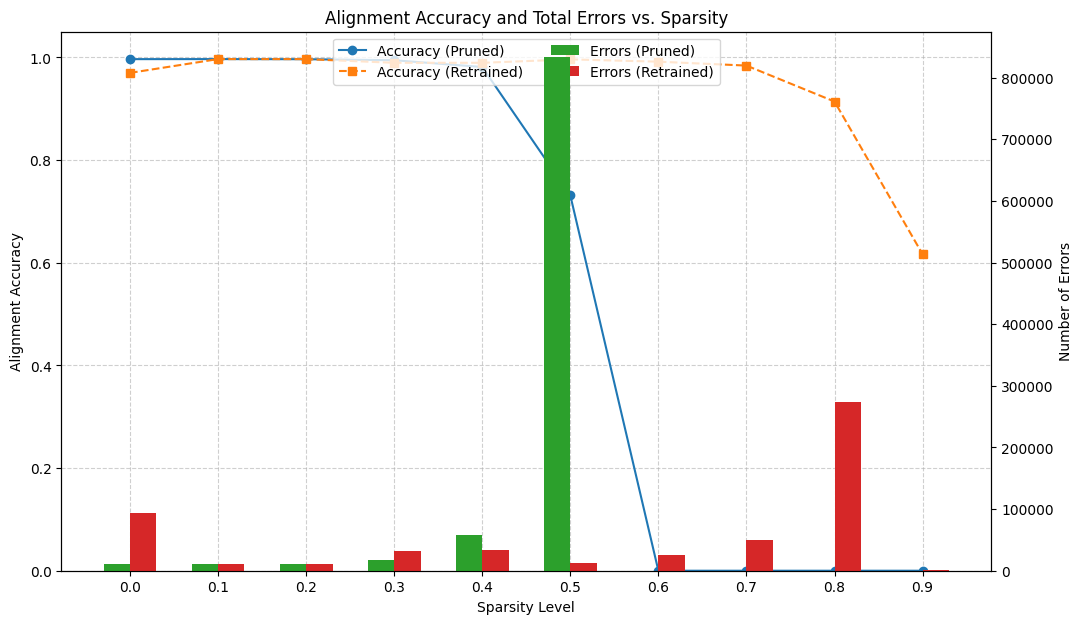

In [123]:
import matplotlib.pyplot as plt
import numpy as np

data = {a: b for a,b in list(data.items()) + list(data2.items())}

# Extract sparsity levels and metrics
sparsity_levels = []
accuracy_pruned = []
accuracy_retrained = []
errors_pruned = []
errors_retrained = []

for i in range(0, 10):
    sparsity = round(i * 0.1, 1)
    sparse_key = f'sparse_{sparsity}'
    retrained_key = f'sparse_{sparsity}_retrained'

    sparsity_levels.append(sparsity)

    # Alignment accuracy
    accuracy_pruned.append(float(data[sparse_key]['alignment_accuracy']))
    accuracy_retrained.append(float(data[retrained_key]['alignment_accuracy']))

    # Total errors: deletions + insertions + substitutions
    errors_p = (int(data[sparse_key]['alignment_num_deletions']) +
                int(data[sparse_key]['alignment_num_insertions']) +
                int(data[sparse_key]['alignment_num_substitutions']))
    errors_r = (int(data[retrained_key]['alignment_num_deletions']) +
                int(data[retrained_key]['alignment_num_insertions']) +
                int(data[retrained_key]['alignment_num_substitutions']))

    errors_pruned.append(errors_p)
    errors_retrained.append(errors_r)

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 7))

# Plot alignment accuracy (left y-axis)
ax1.plot(sparsity_levels, accuracy_pruned, 'o-', color='tab:blue', label='Accuracy (Pruned)')
ax1.plot(sparsity_levels, accuracy_retrained, 's--', color='tab:orange', label='Accuracy (Retrained)')
ax1.set_xlabel('Sparsity Level')
ax1.set_ylabel('Alignment Accuracy', color='black')
ax1.set_ylim(0, 1.05)
ax1.tick_params(axis='y')

# Secondary y-axis for errors
ax2 = ax1.twinx()
width = 0.03  # Bar width

# Plot number of errors (right y-axis)
ax2.bar(np.array(sparsity_levels) - width/2, errors_pruned, width=width, color='tab:green', label='Errors (Pruned)')
ax2.bar(np.array(sparsity_levels) + width/2, errors_retrained, width=width, color='tab:red', label='Errors (Retrained)')
ax2.set_ylabel('Number of Errors', color='black')
ax2.tick_params(axis='y')

# Legends
lines_labels = ax1.get_legend_handles_labels()
bars_labels = ax2.get_legend_handles_labels()
ax1.legend(lines_labels[0] + bars_labels[0], lines_labels[1] + bars_labels[1], loc='upper center', ncol=2)

# Grid and formatting
ax1.grid(True, linestyle='--', alpha=0.6)
plt.title('Alignment Accuracy and Total Errors vs. Sparsity')
plt.xticks(sparsity_levels)

plt.show()


# One-shot masked untrained:

In [126]:
# data = {f"sparse_{s}{r}": tsv_dict(f"one_shot/sparse_{s}{r}", "run") for s in [a/10 for a in range(10)] for r in [""]}
# make_table_switched(data)

# One-shot masked trained:

In [132]:
data2 = {f"sparse_{s}{r}": tsv_dict(f"one_shot/sparse_{s}{r}", "run") for s in [a/10 for a in range(10)] for r in ["_retrained"]}
data2["sparse_0.1_retrained"] = tsv_dict("test/sparse_0.1_masked_retrained", "run")
data2["sparse_0.2_retrained"] = tsv_dict("test/sparse_0.2_masked_retrained", "run")
make_table_switched(data2)

| Model | accuracy | identity | strand_coverage | num_correct | num_deletions | num_insertions | num_substitutions |
|-------|--------|--------|--------|--------|--------|--------|--------|
| sparse_0.0_retrained | 0.967845 | 0.981753 | 1 | 3011115 | 39756 | 4319 | 55964 |
| sparse_0.1_retrained | 0.99664 | 0.998989 | 1 | 3097007 | 6689 | 617 | 3135 |
| sparse_0.2_retrained | 0.996539 | 0.998821 | 1 | 3096910 | 6264 | 834 | 3657 |
| sparse_0.3_retrained | 0.99642 | 0.998685 | 1 | 3096180 | 6574 | 473 | 4077 |
| sparse_0.4_retrained | 0.99092 | 0.998205 | 0.999998 | 3079222 | 22061 | 616 | 5538 |
| sparse_0.5_retrained | 0.995352 | 0.998477 | 1 | 3093128 | 8985 | 741 | 4719 |
| sparse_0.6_retrained | 0.991217 | 0.997648 | 1 | 3080150 | 19421 | 609 | 7262 |
| sparse_0.7_retrained | 0.940584 | 0.967219 | 0.999999 | 2930295 | 77227 | 8565 | 99313 |
| sparse_0.8_retrained | 0 | 0 | 0 | 0 | 0 | 0 | 0 |
| sparse_0.9_retrained | 0 | 0 | 0 | 0 | 0 | 0 | 0 |

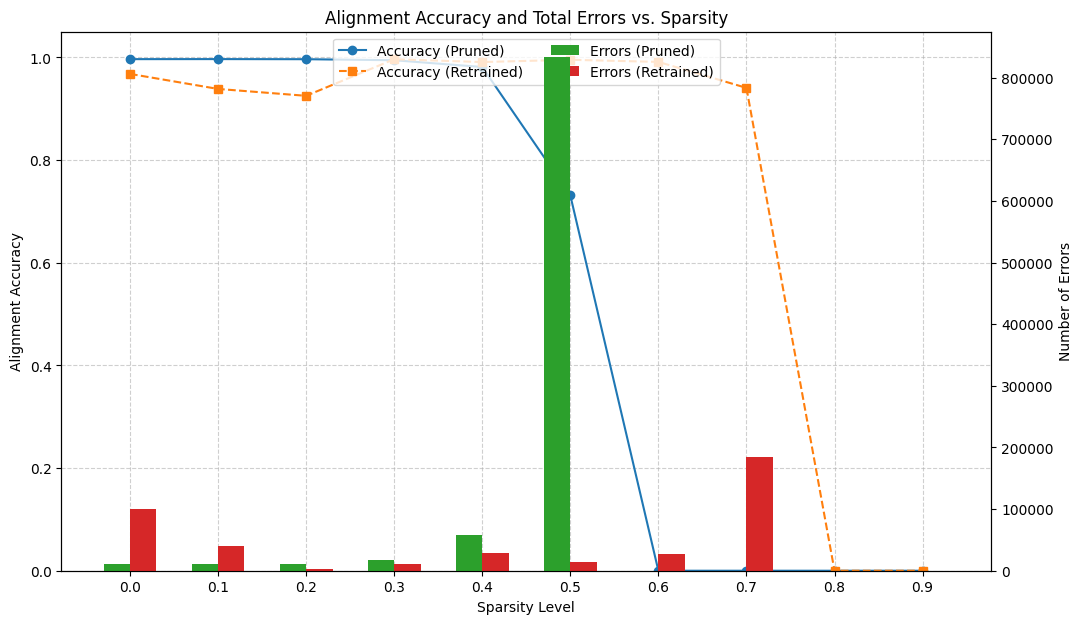

In [97]:
import matplotlib.pyplot as plt
import numpy as np

# Extract sparsity levels and metrics
sparsity_levels = []
accuracy_pruned = []
accuracy_retrained = []
errors_pruned = []
errors_retrained = []

for i in range(0, 10):
    sparsity = round(i * 0.1, 1)
    sparse_key = f'sparse_{sparsity}'
    retrained_key = f'sparse_{sparsity}_retrained'

    sparsity_levels.append(sparsity)

    # Alignment accuracy
    accuracy_pruned.append(float(data[sparse_key]['alignment_accuracy']))
    accuracy_retrained.append(float(data[retrained_key]['alignment_accuracy']))

    # Total errors: deletions + insertions + substitutions
    errors_p = (int(data[sparse_key]['alignment_num_deletions']) +
                int(data[sparse_key]['alignment_num_insertions']) +
                int(data[sparse_key]['alignment_num_substitutions']))
    errors_r = (int(data[retrained_key]['alignment_num_deletions']) +
                int(data[retrained_key]['alignment_num_insertions']) +
                int(data[retrained_key]['alignment_num_substitutions']))

    errors_pruned.append(errors_p)
    errors_retrained.append(errors_r)

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 7))

# Plot alignment accuracy (left y-axis)
ax1.plot(sparsity_levels, accuracy_pruned, 'o-', color='tab:blue', label='Accuracy (Pruned)')
ax1.plot(sparsity_levels, accuracy_retrained, 's--', color='tab:orange', label='Accuracy (Retrained)')
ax1.set_xlabel('Sparsity Level')
ax1.set_ylabel('Alignment Accuracy', color='black')
ax1.set_ylim(0, 1.05)
ax1.tick_params(axis='y')

# Secondary y-axis for errors
ax2 = ax1.twinx()
width = 0.03  # Bar width

# Plot number of errors (right y-axis)
ax2.bar(np.array(sparsity_levels) - width/2, errors_pruned, width=width, color='tab:green', label='Errors (Pruned)')
ax2.bar(np.array(sparsity_levels) + width/2, errors_retrained, width=width, color='tab:red', label='Errors (Retrained)')
ax2.set_ylabel('Number of Errors', color='black')
ax2.tick_params(axis='y')

# Legends
lines_labels = ax1.get_legend_handles_labels()
bars_labels = ax2.get_legend_handles_labels()
ax1.legend(lines_labels[0] + bars_labels[0], lines_labels[1] + bars_labels[1], loc='upper center', ncol=2)

# Grid and formatting
ax1.grid(True, linestyle='--', alpha=0.6)
plt.title('Alignment Accuracy and Total Errors vs. Sparsity')
plt.xticks(sparsity_levels)

plt.show()


For iterative pruning we do the following:

In [62]:
iteration = 8
step_sparsity = 0.75

pairs = [f'"{i} {1-step_sparsity**i}"' for i in range(1, iteration+1)]
bash([
  "cp -r ../models/bje iter_0_retrained",
f"""for pair in {" ".join(pairs)}; do
  read i s <<< "$pair" &&
  {bonito_env} &&
  python3 one_shot_masked.py iter_$((i - 1))_retrained ${{s}} iter_${{i}} &&
  bonito export iter_${{i}} --output iter_${{i}}/export &&
  bonito train iter_${{i}}_retrained --directory ../models/train_data/je --epochs 5 --chunks 200 --valid-chunks 50 --pretrained iter_${{i}} --batch 32 &&
  bonito export iter_${{i}}_retrained --output iter_${{i}}_retrained/export &&
  {dorado_env} &&
  dorado basecaller iter_${{i}}/export {pod5} --reference {fasta} > iter_${{i}}/run.bam 2> >(tee iter_${{i}}/run.log >&2) &&
  dorado summary iter_${{i}}/run.bam > iter_${{i}}/run.tsv &&
  dorado basecaller iter_${{i}}/export {pod5_short} --reference {fasta} > iter_${{i}}/short.bam 2> >(tee iter_${{i}}/short.log >&2) &&
  dorado summary iter_${{i}}/short.bam > iter_${{i}}/short.tsv &&
  dorado basecaller iter_${{i}}_retrained/export {pod5} --reference {fasta} > iter_${{i}}_retrained/run.bam 2> >(tee iter_${{i}}_retrained/run.log >&2) &&
  dorado summary iter_${{i}}_retrained/run.bam > iter_${{i}}_retrained/run.tsv
  dorado basecaller iter_${{i}}_retrained/export {pod5_short} --reference {fasta} > iter_${{i}}_retrained/short.bam 2> >(tee iter_${{i}}_retrained/short.log >&2) &&
  dorado summary iter_${{i}}_retrained/short.bam > iter_${{i}}_retrained/short.tsv
done""",
  "mkdir -p iterative_0.25",
  "mv iter_* iterative_0.25"
])

```bash
cp -r ../models/bje iter_0_retrained && 
for pair in "1 0.25" "2 0.4375" "3 0.578125" "4 0.68359375" "5 0.7626953125" "6 0.822021484375" "7 0.86651611328125" "8 0.8998870849609375"; do
  read i s <<< "$pair" &&
  source /vol/bitbucket/bl1821/bonito_env/bin/activate &&
  python3 one_shot_masked.py iter_$((i - 1))_retrained ${s} iter_${i} &&
  bonito export iter_${i} --output iter_${i}/export &&
  bonito train iter_${i}_retrained --directory ../models/train_data/je --epochs 5 --chunks 200 --valid-chunks 50 --pretrained iter_${i} --batch 32 &&
  bonito export iter_${i}_retrained --output iter_${i}_retrained/export &&
  source /vol/bitbucket/bl1821/pyenv/bin/activate &&
  dorado basecaller iter_${i}/export /vol/bitbucket/bl1821/frankenstein/data/atotc.pod5 --reference /vol/bitbucket/bl1821/frankenstein/data/atotc.fasta > iter_${i}/run.bam 2> >(tee iter_${i}/run.log >&2) &&
  dorado summary iter_${i}/run.bam > iter_${i}/run.tsv &&
  dorado basecaller iter_${i}/export /vol/bitbucket/bl1821/frankenstein/data/atotc_short.pod5 --reference /vol/bitbucket/bl1821/frankenstein/data/atotc.fasta > iter_${i}/short.bam 2> >(tee iter_${i}/short.log >&2) &&
  dorado summary iter_${i}/short.bam > iter_${i}/short.tsv &&
  dorado basecaller iter_${i}_retrained/export /vol/bitbucket/bl1821/frankenstein/data/atotc.pod5 --reference /vol/bitbucket/bl1821/frankenstein/data/atotc.fasta > iter_${i}_retrained/run.bam 2> >(tee iter_${i}_retrained/run.log >&2) &&
  dorado summary iter_${i}_retrained/run.bam > iter_${i}_retrained/run.tsv
  dorado basecaller iter_${i}_retrained/export /vol/bitbucket/bl1821/frankenstein/data/atotc_short.pod5 --reference /vol/bitbucket/bl1821/frankenstein/data/atotc.fasta > iter_${i}_retrained/short.bam 2> >(tee iter_${i}_retrained/short.log >&2) &&
  dorado summary iter_${i}_retrained/short.bam > iter_${i}_retrained/short.tsv
done && 
mkdir -p iterative_0.25 && 
mv iter_* iterative_0.25
```

# Iterative trained:

In [ ]:
data = {f"iter_{s}{r}": tsv_dict(f"iterative_0.25/iter_{s}{r}", "run") for s in range(1,9) for r in ["_retrained"]}
data["iter_1_retrained"] = tsv_dict("test/sparse_0.25_retrained", "run")
make_table_switched(data)

| Model | accuracy | identity | strand_coverage | num_correct | num_deletions | num_insertions | num_substitutions |
|-------|--------|--------|--------|--------|--------|--------|--------|
| iter_1_retrained | 0.991175 | 0.998106 | 0.999998 | 3080007 | 20973 | 606 | 5845 |
| iter_2_retrained | 0.98764 | 0.998397 | 1 | 3068706 | 33202 | 277 | 4926 |
| iter_3_retrained | 0.991904 | 0.997118 | 1 | 3082470 | 15451 | 799 | 8910 |
| iter_4_retrained | 0.986488 | 0.995782 | 1 | 3065845 | 28001 | 1006 | 12985 |
| iter_5_retrained | 0.963375 | 0.985656 | 0.999998 | 2995494 | 67737 | 2551 | 43594 |
| iter_6_retrained | 0.919071 | 0.970055 | 0.999998 | 2860088 | 158447 | 5110 | 88290 |
| iter_7_retrained | 0.798689 | 0.939301 | 0.996931 | 2486599 | 448908 | 17154 | 160688 |
| iter_8_retrained | 0.598273 | 0.843763 | 0.00259586 | 4018 | 982 | 972 | 744 |

: 

# One-shot trained:

In [131]:
data2 = {f"sparse_{s}{r}": tsv_dict(f"one_shot/sparse_{s}{r}", "run") for s in [1-0.75**a for a in range(1,9)] for r in ["_retrained"]}
make_table_switched(data2)

| Model | accuracy | identity | strand_coverage | num_correct | num_deletions | num_insertions | num_substitutions |
|-------|--------|--------|--------|--------|--------|--------|--------|
| sparse_0.25_retrained | 0.99112 | 0.998144 | 0.999998 | 3079822 | 21277 | 590 | 5726 |
| sparse_0.4375_retrained | 0.985497 | 0.997936 | 1 | 3062420 | 38080 | 654 | 6335 |
| sparse_0.578125_retrained | 0.991197 | 0.998315 | 1 | 3079886 | 21750 | 407 | 5197 |
| sparse_0.68359375_retrained | 0.962205 | 0.981039 | 1 | 2993814 | 55163 | 4569 | 57864 |
| sparse_0.7626953125_retrained | 0.717424 | 0.889102 | 0.0171468 | 38563 | 9569 | 810 | 4810 |
| sparse_0.822021484375_retrained | 0 | 0 | 0 | 0 | 0 | 0 | 0 |
| sparse_0.86651611328125_retrained | 0 | 0 | 0 | 0 | 0 | 0 | 0 |
| sparse_0.8998870849609375_retrained | 0 | 0 | 0 | 0 | 0 | 0 | 0 |